# **PPO agent Implementation**

Here we gonna implement the PPO method to be able to compare if the agent is able to learn faster.

In [ ]:
# If on colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install gym-super-mario-bros==7.4.0
!pip install tensordict==0.3.0
!pip install torchrl==0.3.0
!pip install nes-py

# **Imports all needed libs**

In [ ]:
import torch
from torch import nn
from torchvision import transforms as T
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from gym.wrappers.monitoring import video_recorder
import cv2

# **Init and test of the env**

In [38]:
# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
print(gym.__version__)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

0.26.2
(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


# **Preprocess of the env**

In [39]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info

class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation

class ObservationSelection(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(45, 84, 1), dtype=np.uint8)

    def observation(self, observation):
        observation = observation[30:75, :]
        return observation

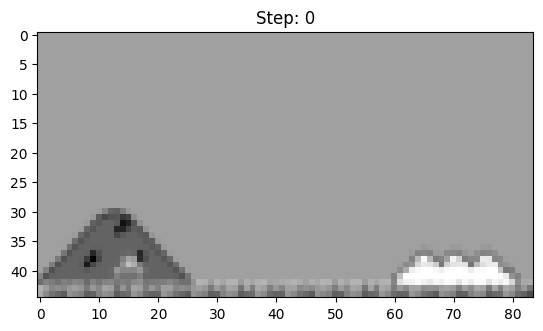

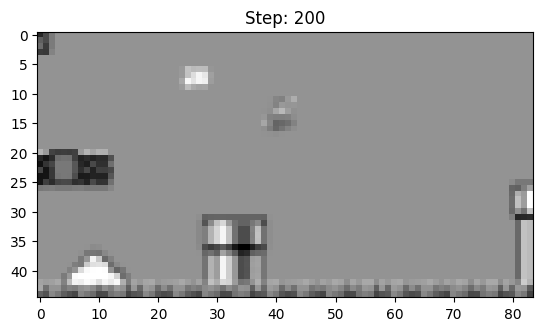

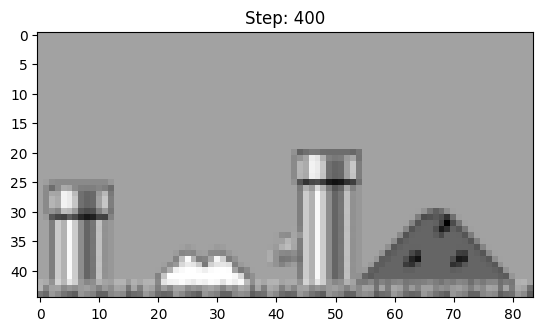

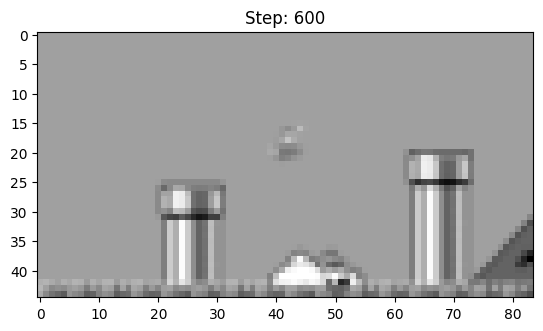

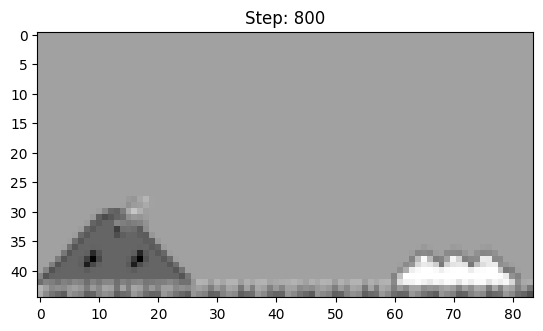

In [40]:
# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = ObservationSelection(env)

if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

# Set the number of steps to run the environment
num_steps = 1000

# Reset the environment
state = env.reset()

# Run the environment for the specified number of steps
for step in range(num_steps):
    # Take a random action
    action = env.action_space.sample()
    next_state, reward, done, truncated, info = env.step(action)

    # Display the state every 200 steps
    if step % 200 == 0:
        plt.imshow(next_state[-1], cmap='gray')
        plt.title(f"Step: {step}")
        plt.show()

    # Update the state
    state = next_state

    # Check if the episode is done
    if done:
        state = env.reset()

# Close the environment
env.close()

# **Definition of the Actor and Critic neural network**

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(np.prod(state_dim), 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(np.prod(state_dim), 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        action_probs = self.actor(state)
        value = self.critic(state)
        return action_probs, value

# **Definition of the mario agent**

In [ ]:
class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        flattened_state_dim = np.prod(state_dim)  # Calculate the flattened state dimension
        self.model = ActorCritic(flattened_state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam([
            {'params': self.model.actor.parameters(), 'lr': lr_actor},
            {'params': self.model.critic.parameters(), 'lr': lr_critic}
        ])
        self.gamma = gamma
        self.K_epochs = K_epochs
        self.eps_clip = eps_clip
        self.memory = []
        self.batch_size = 64

    def select_action(self, state):
        state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
        state = torch.FloatTensor(state).flatten().unsqueeze(0).to(self.device)  # Flatten the state
        action_probs, _ = self.model(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item()

    def update(self, memory):
        states, actions, rewards, next_states, dones = zip(*self.memory)
        states = np.array([state[0].__array__() if isinstance(state, tuple) else state.__array__() for state in states])
        states = torch.FloatTensor(states).flatten(1).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = np.array([state[0].__array__() if isinstance(state, tuple) else state.__array__() for state in next_states])
        next_states = torch.FloatTensor(next_states).flatten(1).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        for _ in range(self.K_epochs):
            action_probs, values = self.model(states)
            dist = Categorical(action_probs)
            action_log_probs = dist.log_prob(actions)

            _, next_values = self.model(next_states)
            returns = self.compute_returns(rewards, next_values, dones)

            advantages = returns - values

            ratio = torch.exp(action_log_probs - action_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()

            critic_loss = 0.5 * (returns - values).pow(2).mean()

            self.optimizer.zero_grad()
            (actor_loss + critic_loss).backward()
            self.optimizer.step()

    def compute_returns(self, rewards, next_values, dones):
        returns = torch.zeros_like(rewards)
        running_return = next_values[-1]
        for t in reversed(range(len(rewards))):
            running_return = rewards[t] + self.gamma * running_return * (1 - dones[t])
            returns[t] = running_return
        return returns

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))

# **Definition of the training process**

Saving process:

1- Save the model based on the average reward over a certain number of episodes instead of relying on a single episode's reward. This helps smooth out the variability and provides a more reliable measure of the agent's performance.

In [ ]:
from tqdm import tqdm
import cv2

In [ ]:
def train(env, agent, num_episodes, max_steps, save_path, save_interval=10):
    info_list = []
    best_mean_reward = -np.inf
    with tqdm(total=num_episodes, desc="Training", unit="episode") as pbar:
        for episode in range(num_episodes):
            state = env.reset()
            episode_reward = 0

            for step in range(max_steps):
                action = agent.select_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                episode_reward += reward

                agent.memory.append((state, action, reward, next_state, done))

                if len(agent.memory) >= agent.batch_size:
                    agent.update(agent.memory)
                    agent.memory = []

                state = next_state

                if done:
                    break

            info_list.append([episode, episode_reward, step])

            if episode % save_interval == 0 and episode > 0:
                mean_reward = np.mean([info[1] for info in info_list[-save_interval:]])
                if mean_reward > best_mean_reward:
                    best_mean_reward = mean_reward
                    agent.save(save_path)

            pbar.set_description(f"Episode {episode+1} - Last Reward: {episode_reward:.2f}")
            pbar.update(1)

    return info_list

In [ ]:
def test_visualized(agent):
   if gym.__version__ < '0.26':
      env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
   else:
      env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='human', apply_api_compatibility=True)

   env = JoypadSpace(env, [["right"], ["right", "A"]])

   env = SkipFrame(env, skip=4)
   env = GrayScaleObservation(env)
   env = ResizeObservation(env, shape=84)
   if gym.__version__ < '0.26':
      env = FrameStack(env, num_stack=4, new_step_api=True)
   else:
      env = FrameStack(env, num_stack=4)

   state = env.reset()
   done = False

   while done == False:
      action = agent.select_action(state)
      state, reward, done, truncated, info = env.step(action)
      env.render()

   env.close()

In [ ]:
# Initialize Super Mario environment (in v0.26 change render mode to 'human' to see results on the screen)
print(gym.__version__)
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb', apply_api_compatibility=True)

# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = ObservationSelection(env)

if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

In [ ]:
state_dim = env.observation_space.shape
action_dim = env.action_space.n

In [ ]:
# Create the PPO agent
agent = PPO(state_dim, action_dim, lr_actor=0.0003, lr_critic=0.0003, gamma=0.99, K_epochs=10, eps_clip=0.2)

In [ ]:
# Train the agent
num_episodes = 25000
max_steps = 2000
save_path = "../best_agent/best_agent_ppo_processed_env.pth"

info_list = train(env, agent, num_episodes, max_steps, save_path)

# **Plot information about the training**

In [ ]:
# Convert info_list to a DataFrame
df = pd.DataFrame(info_list, columns=["Episode", "Reward", "Steps"])

# Plot the reward evolution by episode
plt.figure(figsize=(10, 6))
plt.plot(df["Episode"], df["Reward"])
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward Evolution")

# Calculate the smoothed reward using a rolling window of size 10
smoothed_reward = df["Reward"].rolling(window=10).mean()

# Plot the smoothed reward evolution
plt.figure(figsize=(10, 6))
plt.plot(df["Episode"], smoothed_reward)
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.title("Smoothed Reward Evolution (Window Size: 10)")

plt.show()

# **Test the best agent**

In [ ]:
# Load the best agent
best_agent_path = best_agent_dir / "best_agent.chkpt"
agent.load(best_agent_path)

In [ ]:
# Test the agent
test_visualized(agent)

## --------------